In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import geopandas as gpd

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import functools


%matplotlib inline

import geojson

import json
import datetime
from datetime import timedelta


import utils

plt.rcParams['figure.figsize'] = [10, 10]
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

pd.set_option('display.float_format', '{:.2f}'.format)
import ast


In [2]:
df_mar_19=pd.read_csv('../data_save/df_mar_19.csv',usecols=['poi_cbg', 'visitor_home_cbgs'])  
df_mar_20=pd.read_csv('../data_save/df_mar_20.csv',usecols=['poi_cbg', 'visitor_home_cbgs'])  
df_mar_21=pd.read_csv('../data_save/df_mar_21.csv',usecols=['poi_cbg', 'visitor_home_cbgs']) 
acs=pd.read_csv('../data_save/acs.csv',usecols=['tract_id','income_high','majority_white'])  
boundary=pd.read_csv('../data_save/boundary.csv',usecols=['tract_id','geometry'])
columns_1=['agg_visits','tract_id_ori', 'income_high_ori', 'majority_white_ori', 
           'tract_id_dest', 'income_high_dest', 'majority_white_dest']


In [3]:
def ori_dest_pair(raw_data,time):
    # get the original destination pair with visit counts
    # create a list of datasets each of 1000 rows (except the last one) from the extracted dataset 
    n = 1000 #chunk row size
    chunks_list = [raw_data[i:i+n] for i in range(0,raw_data.shape[0],n)]
    chunks_list
    parsed_df = []
    for sample in chunks_list:
        long_sample = (pd.DataFrame(sample['visitor_home_cbgs'].apply(ast.literal_eval).values.tolist(), index=sample['poi_cbg'])
               .stack()
               .reset_index()
               .rename(columns={'level_1':'ori_cbg', 0:'number of visits'})
               )
        long_sample['number of visits'] = long_sample['number of visits'].astype(int)
        parsed_df.append(long_sample)
    parsed_df = pd.concat(parsed_df)
    df=parsed_df.loc[~parsed_df['ori_cbg'].str.startswith("CA")]

        # transfer the cbg to tract_id
    df['poi_cbg']=df['poi_cbg'].astype(str).str[:11].astype('int64')
    df['ori_cbg']=df['ori_cbg'].astype(str).str[:11].astype('int64')
    agg_county = df.groupby(['poi_cbg', 'ori_cbg']).agg({'number of visits': 'sum'})
    agg_county.columns = ['agg_visits']

    agg_county = agg_county.reset_index()

    agg_county
    print(agg_county.shape)
        # get the socio-economic composition of originial tract
    pd_merge_1=agg_county.merge(acs,left_on='poi_cbg',right_on='tract_id',how='inner')
    pd_merge_2=pd_merge_1.merge(acs,left_on='ori_cbg',right_on='tract_id',how='inner',suffixes=['_dest','_ori'])
    ori_des_acs=pd_merge_2[columns_1]
    path='../data_save/original_destination_pair'+str(time)+'.csv'
    ori_des_acs.to_csv(path)

    return ori_des_acs

In [4]:
# get the socio-economic disitribution of origins
# fvariable is for the destiniation place

def ori_acs_per(raw_data): 
    
    ori_income_high=[]
    ori_income_high_per=[]
    
    ori_income_low=[]
    ori_income_low_per=[]

    ori_income_high_per=[]
    tract=[]
    ori_white=[]
    ori_white_per=[]

    for g in raw_data.groupby(by='tract_id_dest'):
        income=g[1].groupby('income_high_ori')['agg_visits'].sum()
#         print(income.index[0])
        if len(income)==2:
            ori_income_high.append(income.loc[True])
            ori_income_high_per.append(income.loc[True]/(income.loc[False]+income.loc[True]))
       
            ori_income_low_per.append(income.loc[False]/(income.loc[False]+income.loc[True]))
            ori_income_low.append(income.loc[False])
            
        elif  income.index[0]==False:
                ori_income_low.append(income.loc[False])
                ori_income_low_per.append(1)
                ori_income_high.append(0)
                ori_income_high_per.append(0)      
        else:
                ori_income_high.append(income.loc[True])
                ori_income_high_per.append(1)
                ori_income_low.append(0)
                ori_income_low_per.append(0)   
            
#         race=g[1].groupby('majority_white_ori')['agg_visits'].sum()
#         ori_white.append(race[1])
#         white_per=race[1]/(race[0]+race[1])
#         ori_white_per.append(white_per)
        
        tract.append(g[0])
#     print(len(ori_income_high_per),
#           len(ori_income_high),
#           len(ori_income_low_per),
#          len(ori_income_low),
#          len(tract))

    dt={'ori_income_high_per':ori_income_high_per,
        'ori_income_high':ori_income_high,
        'ori_income_low_per':ori_income_low_per,
        'ori_income_low':ori_income_low,
#         'ori_white_per':ori_white_per,
#         'ori_white':ori_white,
        'tract_id':tract}

    acs_df=pd.DataFrame(data=dt)
    
    return acs_df



In [5]:
# get the original-destination pair and combined with acs data
ori_des_acs_2019=ori_dest_pair(df_mar_19,'mar_2019')
ori_des_acs_2019.head()
tract_2019=ori_acs_per(ori_des_acs_2019)
tract_2019

C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poi_cbg']=df['poi_cbg'].astype(str).str[:11].astype('int64')
C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ori_cbg']=df['ori_cbg'].astype(str).str[:11].astype('int64')


(620827, 3)


,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
0,0.51,85,0.49,81,36005000200
1,0.57,603,0.43,446,36005000400
2,0.65,48,0.35,26,36005001600
3,0.58,306,0.42,218,36005001900
4,0.74,289,0.26,99,36005002300
5,0.68,918,0.32,423,36005002400
6,0.80,28,0.20,7,36005002500
7,0.56,503,0.44,393,36005002701
8,0.59,9869,0.41,6743,36005003900
9,0.68,210,0.32,99,36005004001


In [6]:
# get the original-destination pair and combined with acs data
ori_des_acs_2020=ori_dest_pair(df_mar_20,'mar_2020')
ori_des_acs_2020.head()
tract_2020=ori_acs_per(ori_des_acs_2020)
tract_2020

C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poi_cbg']=df['poi_cbg'].astype(str).str[:11].astype('int64')
C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ori_cbg']=df['ori_cbg'].astype(str).str[:11].astype('int64')


(394682, 3)


,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
0,0.45,46,0.55,56,36005000200
1,0.62,392,0.38,242,36005000400
2,0.67,44,0.33,22,36005001600
3,0.52,250,0.48,230,36005001900
4,0.64,306,0.36,174,36005002300
5,0.72,803,0.28,310,36005002400
6,1.00,8,0.00,0,36005002500
7,0.52,355,0.48,331,36005002701
8,0.56,3600,0.44,2830,36005003900
9,0.70,229,0.30,99,36005004001


In [8]:
# get the original-destination pair and combined with acs data
ori_des_acs_2021=ori_dest_pair(df_mar_21,'mar_2021')
ori_des_acs_2021.head()
tract_2021=ori_acs_per(ori_des_acs_2021)
tract_2021

C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['poi_cbg']=df['poi_cbg'].astype(str).str[:11].astype('int64')
C:\Users\Xiaoyi WU\AppData\Local\Temp\ipykernel_30264\3845546609.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ori_cbg']=df['ori_cbg'].astype(str).str[:11].astype('int64')


(251116, 3)


,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
0,0.46,48,0.54,57,36005000200
1,0.56,311,0.44,243,36005000400
2,0.68,25,0.32,12,36005001600
3,0.62,135,0.38,84,36005001900
4,0.64,110,0.36,61,36005002300
5,0.62,451,0.38,282,36005002400
6,1.00,11,0.00,0,36005002500
7,0.64,247,0.36,138,36005002701
8,0.76,6101,0.24,1962,36005003900
9,0.57,68,0.43,52,36005004001


In [9]:
# validation
tmp_mar_19=pd.read_csv('../data_save/df_mar_19.csv')
a=tmp_mar_19.loc[tmp_mar_19['tract_id']==36047050202]
a.to_csv('../data_save/tmp_1.csv')
ori_des_acs_2019.loc[ori_des_acs_2019['tract_id_dest']==36047050202]
tract_2019.loc[tract_2019['tract_id']==36047050202]

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
432,0.53,32,0.47,28,36047050202


In [10]:
# validation
tmp_mar_20=pd.read_csv('../data_save/df_mar_20.csv')
a=tmp_mar_20.loc[tmp_mar_20['tract_id']==36047050202]
a.to_csv('../data_save/tmp_2.csv')
ori_des_acs_2020.loc[ori_des_acs_2020['tract_id_dest']==36047050202]
tract_2020.loc[tract_2020['tract_id']==36047050202]

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
432,0.27,12,0.73,32,36047050202


In [11]:
# validation
tmp_mar_21=pd.read_csv('../data_save/df_mar_21.csv')
a=tmp_mar_21.loc[tmp_mar_21['tract_id']==36047050202]
a.to_csv('../data_save/tmp_3.csv')
ori_des_acs_2021.loc[ori_des_acs_2021['tract_id_dest']==36047050202]
tract_2021.loc[tract_2021['tract_id']==36047050202]

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id
424,0.00,0,1.00,12,36047050202


In [41]:
df_1=tract_2020.merge(tract_2021,left_on='tract_id',right_on='tract_id',suffixes=['_20','_21'])
acs_change=tract_2019.merge(df_1,left_on='tract_id',right_on='tract_id')
acs_change.to_csv('../data_save/acs_change.csv')
acs_change.head()

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id,ori_income_high_per_20,ori_income_high_20,ori_income_low_per_20,ori_income_low_20,ori_income_high_per_21,ori_income_high_21,ori_income_low_per_21,ori_income_low_21
0,0.51,85,0.49,81,36005000200,0.45,46,0.55,56,0.46,48,0.54,57
1,0.57,603,0.43,446,36005000400,0.62,392,0.38,242,0.56,311,0.44,243
2,0.65,48,0.35,26,36005001600,0.67,44,0.33,22,0.68,25,0.32,12
3,0.58,306,0.42,218,36005001900,0.52,250,0.48,230,0.62,135,0.38,84
4,0.74,289,0.26,99,36005002300,0.64,306,0.36,174,0.64,110,0.36,61


In [30]:
acs_income=acs_change
# only considerate count  
acs_income['income_high_20_19']=(acs_income['ori_income_high_20']-acs_income['ori_income_high'])/(acs_income['ori_income_high'])
acs_income['income_high_21_20']=(acs_income['ori_income_high_21']-acs_income['ori_income_high_20'])/(acs_income['ori_income_high_20'])

In [31]:
# only considerate count without 
acs_income['income_low_20_19']=(acs_income['ori_income_low_20']-acs_income['ori_income_low'])/(acs_income['ori_income_low_20'])
acs_income['income_low_21_20']=(acs_income['ori_income_low_21']-acs_income['ori_income_low_20'])/(acs_income['ori_income_low_20'])


In [32]:
acs_income['high_low_perct_20_19']=acs_income['income_high_20_19']-acs_income['income_low_20_19']

In [33]:
acs_income['high_low_perct_21_20']=acs_income['income_high_21_20']-acs_income['income_low_21_20']

In [34]:
url='https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
r_1=requests.get(url)
features_1 = geojson.loads(r_1.text)
from shapely.geometry import shape, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

GEOID,geometry=[],[]

for e in features_1['features']: 
    GEOID.append(e['properties']["GEOID"])
    ps = shape(e['geometry'])
    geometry.append(
        MultiPolygon(ps) if isinstance(ps, list) else ps
    )

boundary = pd.DataFrame([GEOID,geometry]).T
boundary.columns=['tract_id','geometry']
boundary['tract_id']=boundary['tract_id'].str[:11].astype('int64')
boundary.to_csv('../data_save/boundary.csv')
boundary.head()


,tract_id,geometry
0,36061000100,"(POLYGON ((-74.043879 40.690196, -74.043507000..."
1,36061000201,"POLYGON ((-73.984498 40.709518, -73.986552 40...."
2,36061000202,"(POLYGON ((-73.983644 40.7096, -73.984498 40.7..."
3,36061000500,"(POLYGON ((-74.01093 40.6845, -74.011934 40.68..."
4,36061000600,"POLYGON ((-73.990222 40.714413, -73.989338 40...."


In [35]:
acs_income_boundary=pd.merge(acs_income, boundary,how='inner',left_on=['tract_id'],right_on=['tract_id'])

In [53]:
acs_income_gpg= gpd.GeoDataFrame(acs_income_boundary, geometry='geometry', crs="EPSG:4326")
acs_income_gpg

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id,ori_income_high_per_20,ori_income_high_20,ori_income_low_per_20,ori_income_low_20,ori_income_high_per_21,ori_income_high_21,ori_income_low_per_21,ori_income_low_21,income_high_20_19,income_high_21_20,income_low_20_19,income_low_21_20,high_low_perct_20_19,high_low_perct_21_20,geometry
0,0.51,85,0.49,81,36005000200,0.45,46,0.55,56,0.46,48,0.54,57,-0.46,0.04,-0.45,0.02,-0.01,0.03,"POLYGON ((-73.85652 40.80525, -73.85653 40.805..."
1,0.57,603,0.43,446,36005000400,0.62,392,0.38,242,0.56,311,0.44,243,-0.35,-0.21,-0.84,0.00,0.49,-0.21,"POLYGON ((-73.84611 40.81311, -73.84647 40.812..."
2,0.65,48,0.35,26,36005001600,0.67,44,0.33,22,0.68,25,0.32,12,-0.08,-0.43,-0.18,-0.45,0.10,0.02,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
3,0.74,289,0.26,99,36005002300,0.64,306,0.36,174,0.64,110,0.36,61,0.06,-0.64,0.43,-0.65,-0.37,0.01,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
4,0.68,918,0.32,423,36005002400,0.72,803,0.28,310,0.62,451,0.38,282,-0.13,-0.44,-0.36,-0.09,0.24,-0.35,"POLYGON ((-73.87050 40.82037, -73.87044 40.820..."
5,0.80,28,0.20,7,36005002500,1.00,8,0.00,0,1.00,11,0.00,0,-0.71,0.38,-inf,NaN,inf,NaN,"POLYGON ((-73.91750 40.80682, -73.91765 40.806..."
6,0.56,503,0.44,393,36005002701,0.52,355,0.48,331,0.64,247,0.36,138,-0.29,-0.30,-0.19,-0.58,-0.11,0.28,"POLYGON ((-73.91353 40.80426, -73.91414 40.803..."
7,0.59,9869,0.41,6743,36005003900,0.56,3600,0.44,2830,0.76,6101,0.24,1962,-0.64,0.69,-1.38,-0.31,0.75,1.00,"POLYGON ((-73.91618 40.80880, -73.91640 40.808..."
8,0.68,210,0.32,99,36005004001,0.70,229,0.30,99,0.57,68,0.43,52,0.09,-0.70,0.00,-0.47,0.09,-0.23,"POLYGON ((-73.85615 40.82678, -73.85636 40.826..."
9,0.74,224,0.26,77,36005004100,0.77,157,0.23,48,0.77,87,0.23,26,-0.30,-0.45,-0.60,-0.46,0.31,0.01,"POLYGON ((-73.91485 40.81100, -73.91492 40.810..."


In [37]:
#validation
acs_income_gpg.loc[acs_income_gpg['tract_id']==36005050400]

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id,ori_income_high_per_20,ori_income_high_20,ori_income_low_per_20,ori_income_low_20,ori_income_high_per_21,ori_income_high_21,ori_income_low_per_21,ori_income_low_21,income_high_20_19,income_high_21_20,income_low_20_19,income_low_21_20,high_low_perct_20_19,high_low_perct_21_20,geometry
191,0.67,464,0.33,232,36005050400,0.64,390,0.36,219,0.60,501,0.40,338,-0.16,0.28,-0.06,0.54,-0.10,-0.26,"MULTIPOLYGON (((-73.80222 40.84164, -73.80264 ..."


In [46]:
tmp_mar_19=pd.read_csv('../data_save/df_mar_19.csv')  
tmp_mar_19.loc[tmp_mar_19['tract_id']==36047050202]

,Unnamed: 0,placekey,date_range_start,date_range_end,raw_visit_counts,raw_visitor_counts,visits_by_day,visitor_home_cbgs,poi_cbg,visitor_daytime_cbgs,distance_from_home,bucketed_dwell_times,related_same_day_brand,device_type,median_dwell,bucketed_dwell_times.1,parent_placekey,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,iso_country_code,phone_number,open_hours,category_tags,opened_on,closed_on,tracking_closed_since,geometry_type,pop_up_col,naics_2dig,naics_3dig,category,trac_id,tract_id
36586,36598,zzz-222@627-wh4-f75,2019-03-01 00:00:00-05:00,2019-04-01T00:00:00-04:00,101,79,"[2,2,1,3,2,0,3,4,3,4,1,4,1,4,6,4,5,2,5,2,3,1,9...","{""360470430003"":4,""360470502022"":4,""3401300110...",360470502022,"{""360810166001"":4,""360810549003"":4,""3604705020...",4707.00,"{""<5"":3,""5-10"":50,""11-20"":14,""21-60"":6,""61-120...","{""BP"":3,""Donut Connection"":3,""Dunkin'"":3,""Domi...","{""android"":38,""ios"":43}",10.00,"{""<5"":3,""5-10"":50,""11-20"":14,""21-60"":6,""61-120...",NaN,Sitting Area Seeley,NaN,NaN,"Museums, Historical Sites, and Similar Institu...",Nature Parks and Other Similar Institutions,712190,40.65,-73.98,Sitting Area Seeley,New York,NY,11218,US,NaN,NaN,NaN,NaN,NaN,2019-07-01,POLYGON,name: Sitting Area Seeley；type:Nature Parks an...,71,712,Recreation,360470502022,36047050202


In [47]:
acs_income_gpg.loc[acs_income_gpg['tract_id']==36047050202]

,ori_income_high_per,ori_income_high,ori_income_low_per,ori_income_low,tract_id,ori_income_high_per_20,ori_income_high_20,ori_income_low_per_20,ori_income_low_20,ori_income_high_per_21,ori_income_high_21,ori_income_low_per_21,ori_income_low_21,income_high_20_19,income_high_21_20,income_low_20_19,income_low_21_20,high_low_perct_20_19,high_low_perct_21_20,geometry
383,0.53,32,0.47,28,36047050202,0.27,12,0.73,32,0.00,0,1.00,12,-0.62,-1.00,0.12,-0.62,-0.75,-0.38,"POLYGON ((-73.97268 40.65265, -73.97400 40.652..."


### change in high-income group from 2020 to 2019

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


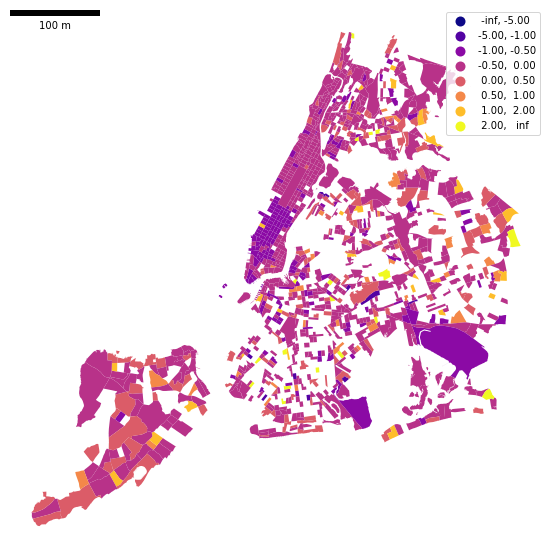

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
bin=[-5,-1,-0.5,0,0.5,1,2.00]
acs_income_gpg.plot(ax=ax, column='income_high_20_19',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='income_high_20_19'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))



In [63]:
### change in low-income group from 2020 to 2019

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:882: RuntimeWarning: invalid value encountered in subtract
  ycd = np.abs(yc - yc_med)


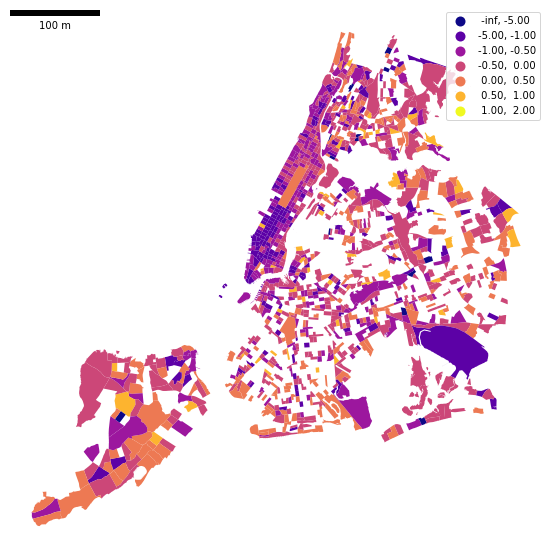

In [64]:
fig, ax = plt.subplots(figsize=(10,10))
bin=[-5,-1,-0.5,0,0.5,1,2.00]
acs_income_gpg.plot(ax=ax, column='income_low_20_19',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='income_high_20_19'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))



### change in high-income group from 2021 to 2020

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:882: RuntimeWarning: invalid value encountered in subtract
  ycd = np.abs(yc - yc_med)


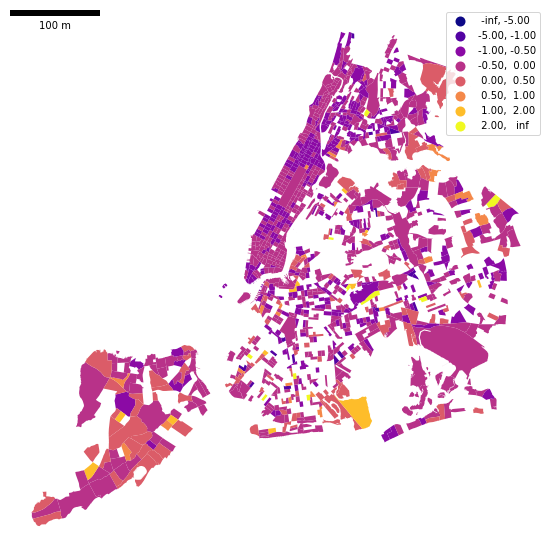

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
bin=[-5,-1,-0.5,0,0.5,1,2.00]
acs_income_gpg.plot(ax=ax, column='income_high_21_20',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='income_high_21_20'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))



### change in low-income group from 2021 to 2020

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:882: RuntimeWarning: invalid value encountered in subtract
  ycd = np.abs(yc - yc_med)


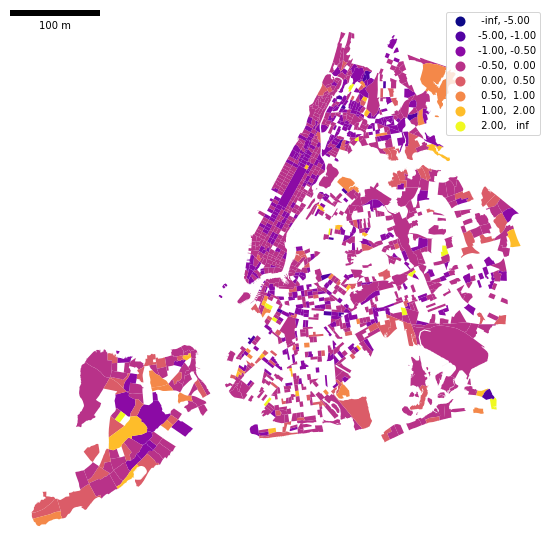

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
bin=[-5,-1,-0.5,0,0.5,1,2.00]
acs_income_gpg.plot(ax=ax, column='income_low_21_20',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='income_low_21_20'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))



### change in 2019 and 2020 between high and low income group

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


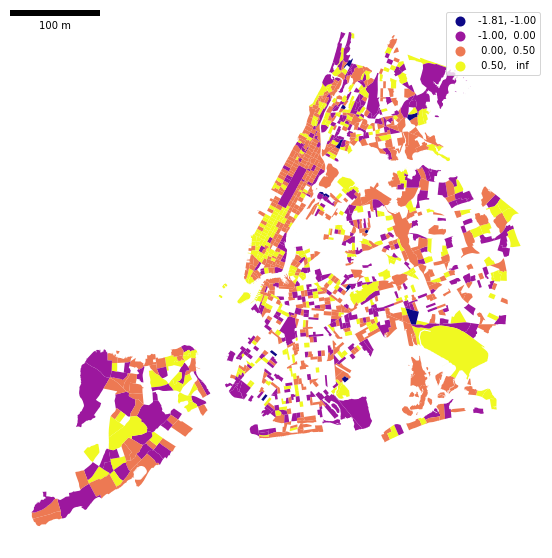

In [76]:
#low-income people have higher decreasing to light color-place
fig, ax = plt.subplots(figsize=(10,10))
bin=[-1,0,0.5]
acs_income_gpg.plot(ax=ax, column='high_low_perct_20_19',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='high_low_perct_20_19'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))



### change in 2020 and 2021 between high and low income group

C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:860: RuntimeWarning: invalid value encountered in subtract
  css = yc - yc.mean()
C:\Users\Xiaoyi WU\.conda\envs\py38\lib\site-packages\mapclassify\classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


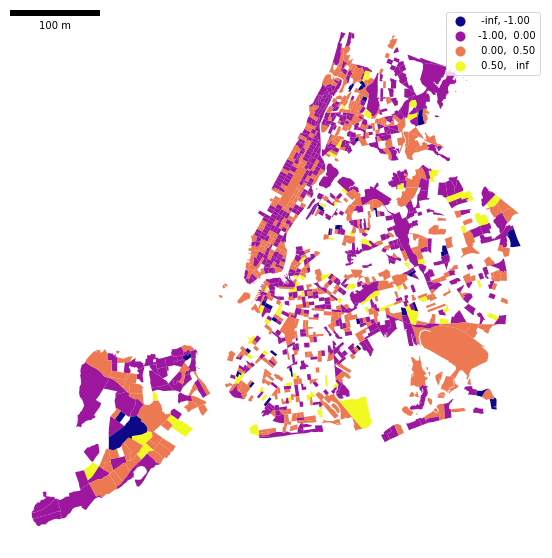

In [75]:
#low-income people have lower decreasing to light color-place

fig, ax = plt.subplots(figsize=(10,10))
bin=[-1,0,0.5]
acs_income_gpg.plot(ax=ax, column='high_low_perct_21_20',
              scheme='user_defined',
              cmap='plasma',
              classification_kwds={'bins':bin},
              legend=True,
#               missing_kwds={
#         "color": "lightgrey",
#         "label": "Missing data",
#     }
             )
title='high_low_perct_21_20'   
path='../fig/'+title+'.jpg'
#     ax.set_title(title, fontsize=16)
ax.set_axis_off()
fig.savefig(path)
ax.add_artist(ScaleBar(1,location='upper left',dimension="si-length", units="km"))

